In [861]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as spatial
from Helpers import helpers, twod_laplace

In [862]:
plain_df, perturbed_df = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/heart-dataset/heart_numerical.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/heart-dataset/")

In [863]:
plain_df = plain_df.drop(columns=['class'])
plain_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks
0,120.0,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0
1,132.0,4.0,0.0,4.0,2.0,130.0,68.0,198.0,6.0
2,133.0,2.0,0.0,5.0,2.0,130.0,68.0,198.0,5.0
3,134.0,2.0,0.0,6.0,2.0,117.0,53.0,170.0,11.0
4,132.0,4.0,0.0,5.0,0.0,117.0,53.0,170.0,9.0


In [864]:
plain_df_2d = plain_df.loc[:, ['baseline value', 'histogram_min']]
perturbed_df_2d = perturbed_df.loc[:, ['baseline value', 'histogram_min']]
plain_df_2d.head()

,baseline value,histogram_min
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [865]:
import random
from sklearn.preprocessing import MinMaxScaler

def get_Z_outside_domain_X(plain_df, perturbed_df):
    tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask

def get_radius_and_perturbation(plain_df, epsilon):
    data = {'r': [], 'x': [], 'y': []}
    # loop through each record
    for row in plain_df.values:
        p = random.random()
        theta = np.random.rand()*np.pi*2
        r = twod_laplace.inverseCumulativeGamma(epsilon, p) # draw radius distance
        private_point = twod_laplace.addVectorToPoint(row, r, theta)
        data['r'].append(r)
        data['x'].append(private_point[0])
        data['y'].append(private_point[1])

    return pd.DataFrame(data)

def transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

def inverse_transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.inverse_transform(dataframe), columns=dataframe.columns)



In [866]:
tree = spatial.KDTree(plain_df_2d)
query_data = tree.query_ball_point([132.0,4.0], r=0.3)
plain_df_2d.iloc[query_data]

,baseline value,histogram_min


In [867]:
min_max_scaler = MinMaxScaler(feature_range=[-1,1])
min_max_scaler_perturbed = MinMaxScaler(feature_range=[-1,1])


In [868]:
perturbed_data_with_r = get_radius_and_perturbation(plain_df_2d, 0.1)
perturbed_data_with_r.head()

,r,x,y
0,25.00071,142.092105,73.703605
1,9.36646,123.742720,72.421300
2,16.00737,141.711450,81.429316
3,20.34962,137.330065,32.924699
4,28.24815,148.882668,75.648035


In [869]:
outside_domain_mask = get_Z_outside_domain_X(plain_df_2d.values, perturbed_data_with_r.drop(columns=['r']).values)
perturbed_data_with_r_outside_domain = perturbed_data_with_r.drop(columns=['r'])[outside_domain_mask]
perturbed_data_with_r_outside_domain = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain], axis=1)

In [870]:
perturbed_data_with_r_outside_domain.head()

,r,x,y
3,20.34962,137.330065,32.924699
5,37.84693,99.039226,64.496013
6,36.64138,97.633821,45.517621
7,44.72485,105.060901,20.607016
11,55.43110,161.223836,110.282892


In [871]:
# perturbed_data_with_r_outside_domain_scaled = pd.DataFrame(min_max_scaler.fit_transform(perturbed_data_with_r_outside_domain), columns=perturbed_data_with_r_outside_domain.columns)


In [872]:
random_point = perturbed_data_with_r_outside_domain.iloc[2]
plain_tree = spatial.KDTree(plain_df_2d)
perturbed_query_data = plain_tree.query_ball_point([random_point['x'], random_point['y']], r=random_point['r'])

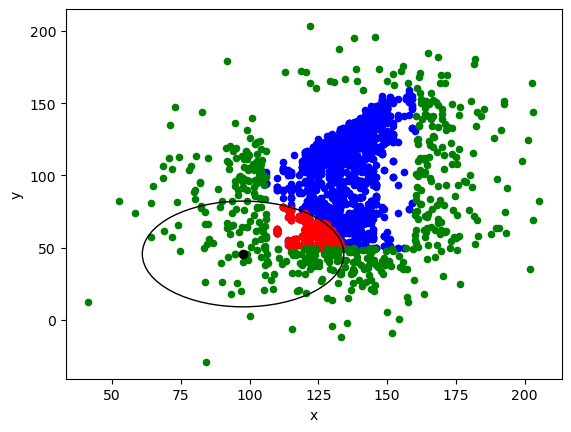

In [873]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
plain_df_2d.iloc[perturbed_query_data].plot(kind='scatter', x='baseline value', y='histogram_min', color='red', ax=ax)
perturbed_data_with_r_outside_domain.plot(kind='scatter', x='x', y='y', color='green', ax=ax)
ax.add_patch(plt.Circle((random_point['x'], random_point['y']), random_point['r'], color='black', fill=False))
ax.scatter(random_point['x'], random_point['y'], color='black')

In [874]:
perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10)
perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['baseline value', 'histogram_min'])
perturbed_data_with_r_outside_domain_remapped = perturbed_data_with_r_remapped.iloc[perturbed_data_with_r_outside_domain.index]
print(perturbed_data_with_r_remapped.shape, perturbed_data_with_r_outside_domain_remapped.shape)

(2126, 2) (505, 2)


In [875]:
perturbed_data_with_r_outside_domain_remapped = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=True)
perturbed_data_with_r_outside_domain_remapped.head()

,r,x,y
3,20.34962,136.0,50.000000
5,37.84693,106.0,62.111111
6,36.64138,106.0,50.000000
7,44.72485,106.0,50.000000
11,55.43110,160.0,110.555556


<AxesSubplot:xlabel='x', ylabel='y'>

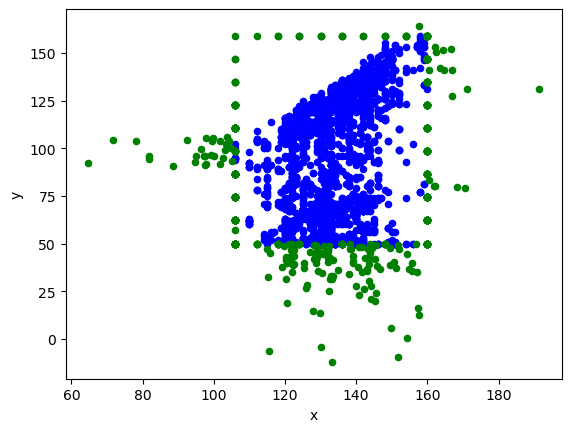

In [876]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='green', ax=ax)


In [894]:
import math
import scipy.spatial as spatial


def calculate_distance(point1, point2):
    return spatial.distance.euclidean(point1, point2)  # Euclidean distance as an example

def remap_point(x, z, real_data, radius, epsilon, plain_tree, w_x):
    w_x = len(w_x)
    #w_q_sum = sum([len(calculate_popularity(q, real_data, radius)) for q in Q_r(x, z, real_data, radius)])
    q = Q_r(x, z, real_data, radius, plain_tree)
    w_q_sum = len(q)
    # q_calc = (w_q_sum * math.exp(-epsilon * calculate_distance(q, z)))
    #print(w_q_sum)
    distance_xz = calculate_distance(x, z)
    
    epsilon_offset = 1e-6  # Small offset to avoid division by zero or infinite results
    
    remapped_value = (w_x * math.exp(-epsilon * distance_xz)) / w_q_sum if w_q_sum > 0 else 0
    return remapped_value

def Q_r(x, z, points, radius, kd_tree=None):
    kdtree = spatial.KDTree(points) if kd_tree is None else kd_tree
    conc = np.concatenate((x, z))
    indices = kdtree.query_ball_point(conc, radius)
    return [points[i] for i in indices]

def find_new_r_for_perturbed_datas_outside_domain(perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_with_Q = perturbed_data.copy()
    for index, point in perturbed_data_with_Q.iterrows():
        x = plain_df.iloc[index]
        new_r = { 'x_new': [], 'y_new': []}
        for column in ['x', 'y']:
            #print(point[column], x[column])
            polularity_x = Q_r([x[column]], [point[column]], plain_df[column].values, point['r'], plain_tree)
            #new_r[f"{column}_new"].append(remap_point([plain_df.loc[index,column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            for x_q in polularity_x:
                new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))

            coefficients = [x_new * x[column] for x_new in new_r[f"{column}_new"]] 
            sum_coefficients = sum(coefficients)
            
            probabilities = [coeff / sum_coefficients for coeff in coefficients]
            if(sum_coefficients > 0):         
                perturbed_data_with_Q.loc[index, f"{column}_new"] = np.average(polularity_x, axis=0, weights=probabilities)
        
    return perturbed_data_with_Q; 

In [895]:
plain_df_2d.head()
plain_df_2d_renamed = plain_df_2d.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=False)
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [896]:
counts = find_new_r_for_perturbed_datas_outside_domain(perturbed_data_with_r_outside_domain_remapped, plain_df_2d_renamed)

#counts = counts.where(counts['Q_r'] > 0).dropna()

/tmp/ipykernel_4531/749110127.py:44: RuntimeWarning: invalid value encountered in double_scalars
  probabilities = [coeff / sum_coefficients for coeff in coefficients]


In [901]:
print(counts['y_new'].max(), plain_df_2d_renamed['y'].max(), counts['y_new'].min(), plain_df_2d_renamed['y'].min(), perturbed_data_with_r_outside_domain_remapped['y'].max(), perturbed_data_with_r_outside_domain_remapped['y'].min())
print(counts['x_new'].max(), plain_df_2d_renamed['x'].max(), counts['x_new'].min(), plain_df_2d_renamed['x'].min(), perturbed_data_with_r_outside_domain_remapped['x'].max(), perturbed_data_with_r_outside_domain_remapped['x'].min())

140.6835331647597 159.0 52.54917032018782 50.0 164.12944246757115 -12.076025764664259
151.55409138341443 160.0 110.6430354817356 106.0 191.44384125061896 64.78347119847032


In [902]:
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


$$  \sigma(x) = \frac{w(x)e^{-\epsilon d(x, z)}}{w(q)e^{-\epsilon d(q, z)}}$$

<AxesSubplot:xlabel='x', ylabel='y'>

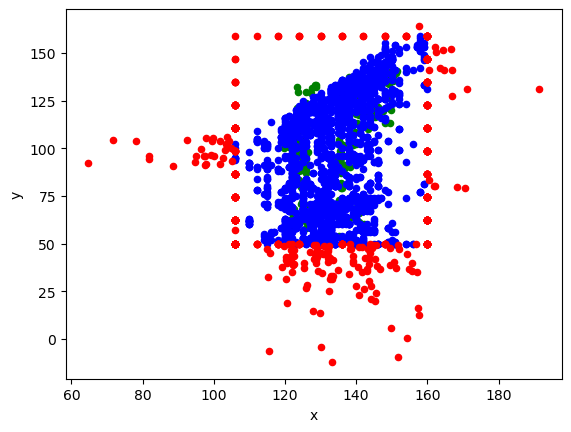

In [909]:
fig, ax = plt.subplots()
counts.plot(kind='scatter', x='x_new', y='y_new', color='green', ax=ax)
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax)
counts.plot(kind='scatter', x='x', y='y', color='red', ax=ax)